In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys
import os

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA



min_nblocks = 2            # min number of blocks for a session to be include
train_len   = 4            # training data length (NOT IMPLEMENTED YET)
max_ndays   = np.inf       # accept all pairs of sessions regardless of time between
min_r       = -1 * np.inf  # subselect days where mean recalibration alone works okayish
sigma       = 2            # causal gaussian smoothing for TXs
task        = None         # subselect any tasks
train_size  = 0.5          # fraction of blocks for training data
participant = 'T5'


save_path   = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/session_pairs2/'
FILE_DIR    = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

filelist    = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)
files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)
pairs             = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs           = len(pairs)


Now generate dictionaries containing data for session-pairs, and save to dataset folder:

In [2]:
def getScreenBounds(struct):
    targpos_data  = struct.targetPos_continuous
    X_min, X_max  = targpos_data[:, 0].min() - 20, targpos_data[:, 0].max() + 20
    Y_min, Y_max  = targpos_data[:, 1].min() - 20, targpos_data[:, 1].max() + 20
    
    return X_min, X_max, Y_min, Y_max


In [7]:
from hmm import *
from hmm_utils import get_DiscreteTargetGrid
import scipy, sklearn
import itertools

pearsons = list()
R2s      = list()

fields   = ['TX', 'cursorPos', 'targetPos']

for i, (A_file, B_file) in enumerate(pairs):
    
    A_date = A_file.split('/t5.')[1].split('.mat')[0]
    B_date = B_file.split('/t5.')[1].split('.mat')[0]
    
    save_fname = os.path.join(save_path,  f'{A_date}_to_{B_date}.npy')
    
    if not os.path.isfile(save_fname): 
        dayA = DataStruct(A_file, alignScreens = True, causal_filter = sigma)
        dayB = DataStruct(B_file, alignScreens = True, causal_filter = sigma)

        dayA_blocks = block_constraints[A_file]
        dayB_blocks = block_constraints[B_file]

        # obtain features and cursorError targets:
        Adata  = getTrainTest(dayA, fields = fields, train_size = train_size, blocks = dayA_blocks, 
                                                             task = task, returnFlattened = True)    
        Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Adata['train_TX'], Adata['test_TX'], concatenate = True)
        Atrain_y     = np.concatenate(Adata['train_targetPos']) - np.concatenate(Adata['train_cursorPos'])
        Atest_y      = np.concatenate(Adata['test_targetPos']) - np.concatenate(Adata['test_cursorPos'])

        Bdata  = getTrainTest(dayB, fields = fields, train_size = train_size, blocks = dayB_blocks, task = task, 
                                                                             returnFlattened = True)    
        Btrain_x, Btest_x  = get_BlockwiseMeanSubtracted(Bdata['train_TX'], Bdata['test_TX'], concatenate = True)
        Btest_x_stalemean  = np.concatenate(Bdata['test_TX']) - np.concatenate(Adata['train_TX']).mean(axis = 0)
        Btrain_y     = np.concatenate(Bdata['train_targetPos']) - np.concatenate(Bdata['train_cursorPos'])
        Btest_y      = np.concatenate(Bdata['test_targetPos']) - np.concatenate(Bdata['test_cursorPos'])
        B_cursorPos  = np.concatenate(Bdata['train_cursorPos'])

        A_decoder = LinearRegression(fit_intercept = False).fit(Atrain_x, Atrain_y)
        B_decoder = LinearRegression(fit_intercept = False).fit(Btrain_x, Btrain_y)

        # no recalibration
        Bpred_y_norecal   = A_decoder.predict(Btest_x_stalemean)
        norecal_R2_score  = sklearn.metrics.r2_score(Btest_y, Bpred_y_norecal)
        norecal_pearson_r = scipy.stats.pearsonr(Btest_y.flatten(), Bpred_y_norecal.flatten())[0]

        # mean recalibration
        Bpred_y_meanrecal   = A_decoder.predict(Btest_x)
        meanrecal_R2_score  = sklearn.metrics.r2_score(Btest_y, Bpred_y_meanrecal)
        meanrecal_pearson_r = scipy.stats.pearsonr(Btest_y.flatten(), Bpred_y_meanrecal.flatten())[0]

        # supervised recalibration
        Bpred_y_suprecal   = B_decoder.predict(Btest_x)
        suprecal_R2_score  = sklearn.metrics.r2_score(Btest_y, Bpred_y_suprecal)
        suprecal_pearson_r = scipy.stats.pearsonr(Btest_y.flatten(), Bpred_y_suprecal.flatten())[0]

        if meanrecal_pearson_r >= min_r:
            # add smoothing and session-specific information
            pair_data = dict()
            pair_data['A_file']     = A_file
            pair_data['B_file']     = B_file
            pair_data['days_apart'] = daysBetween(dayA.date, dayB.date)
            pair_data['task']       = task
            pair_data['train_size'] = train_size
            pair_data['smoothing']  = sigma

            pair_data['A_decoder']  = A_decoder
            pair_data['B_decoder']  = B_decoder

            # no recal
            pair_data['norecal_R2_score']  = norecal_R2_score
            pair_data['norecal_pearson_r'] = norecal_pearson_r

            # mean recal
            pair_data['meanrecal_R2_score']  = meanrecal_R2_score
            pair_data['meanrecal_pearson_r'] = meanrecal_pearson_r

            # supervised recal
            pair_data['suprecal_R2_score']  = suprecal_R2_score
            pair_data['suprecal_pearson_r'] = suprecal_pearson_r

            # data 
            pair_data['A_train_neural']  = Atrain_x
            pair_data['A_test_neural']   = Atest_x
            pair_data['A_train_targvec'] = Atrain_y
            pair_data['A_test_targvec']  = Atest_y

            pair_data['B_train_neural']  = Btrain_x
            pair_data['B_test_neural']   = Btest_x
            pair_data['B_train_targvec'] = Btrain_y
            pair_data['B_test_targvec']  = Btest_y
            pair_data['B_train_cursor']  = B_cursorPos        
            pair_data['B_screenBounds']  = getScreenBounds(dayB)
            
            #np.save(save_fname, pair_data)
            

    if (i + 1) % int(np.round(len(pairs) / 20)) == 0:
        print(np.round((i + 1) * 100 / len(pairs), 1), '% complete')

KeyboardInterrupt: 

In [10]:
dataset_sizes = list()
fields        = ['TX', 'cursorPos', 'targetPos']

for i, A_file in enumerate(files):    
    dayA        = DataStruct(A_file, alignScreens = True, causal_filter = sigma)
    dayA_blocks = block_constraints[A_file]

    # obtain features and cursorError targets:
    Adata  = getTrainTest(dayA, fields = fields, train_size = train_size, blocks = dayA_blocks, 
                                                         task = task, returnFlattened = True)    
    Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Adata['train_TX'], Adata['test_TX'], concatenate = True)

    dataset_sizes.append([Atrain_x.shape[0], Atest_x.shape[0]])
    
    if i % 10 == 0:
        print(i, '/', len(files))

0 / 73
10 / 73
20 / 73
30 / 73
40 / 73
50 / 73
60 / 73
70 / 73


In [24]:
sizes = np.vstack(dataset_sizes)

print('Minimum length (min): ', (min(sizes[:, 0] + sizes[:, 1]) * 0.02) / 60)

Minimum length (min):  4.882000000000001


(array([14., 16., 11.,  9.,  3., 14.,  4.,  0.,  1.,  1.]),
 array([ 14646. ,  26782.5,  38919. ,  51055.5,  63192. ,  75328.5,
         87465. ,  99601.5, 111738. , 123874.5, 136011. ]),
 <BarContainer object of 10 artists>)

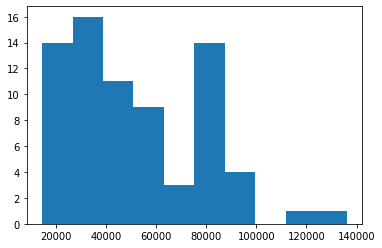

In [18]:
plt.hist(sizes[:, 0] + sizes[:, 1])


[]

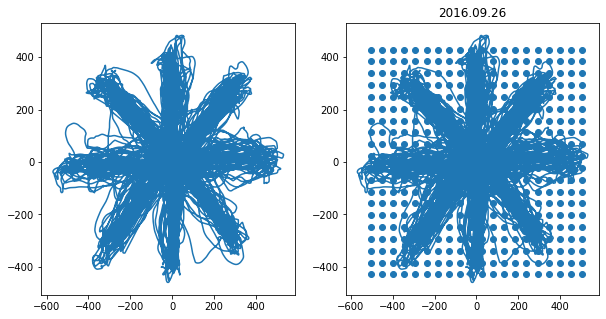

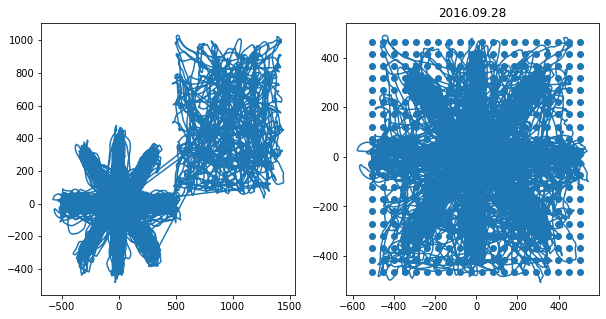

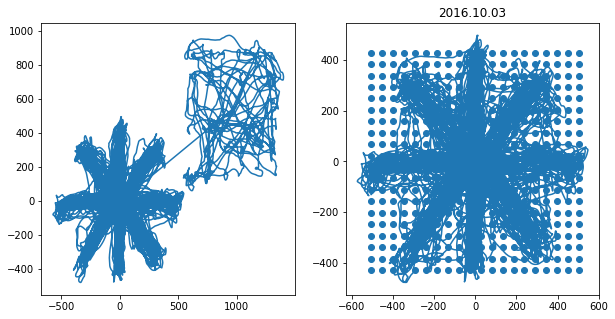

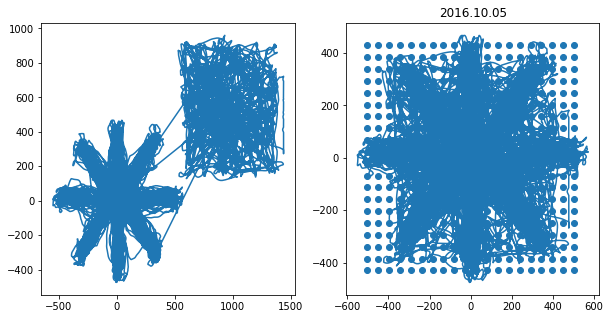

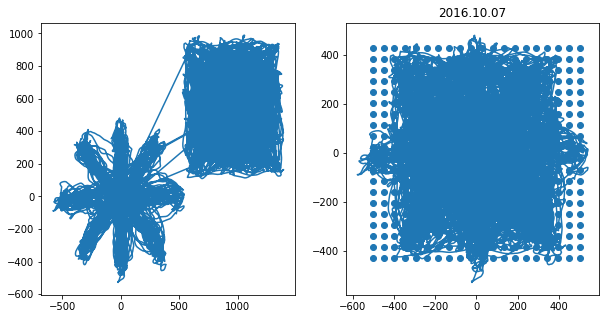

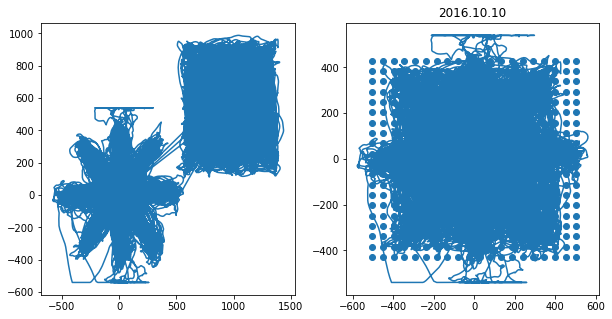

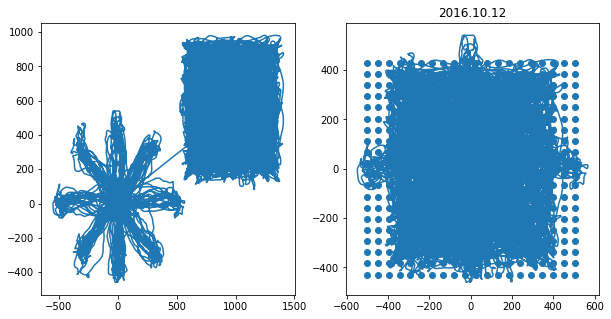

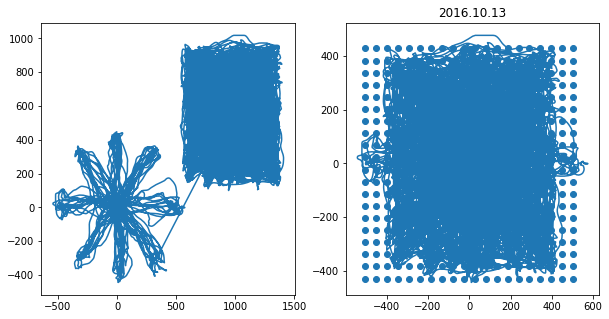

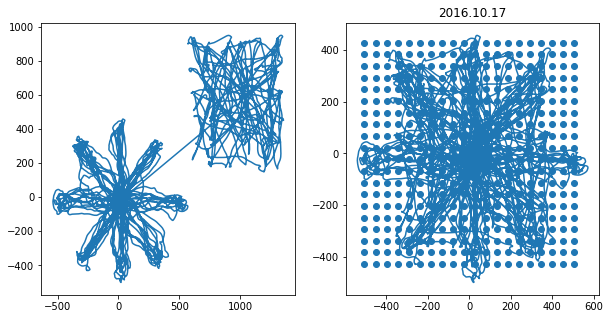

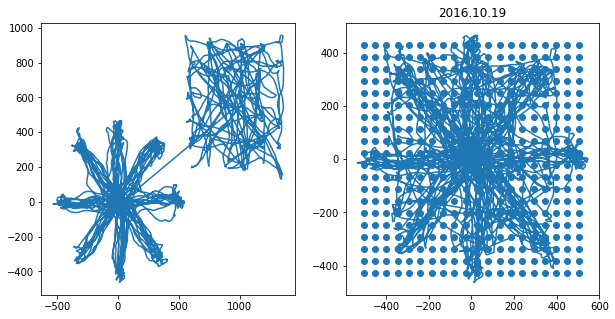

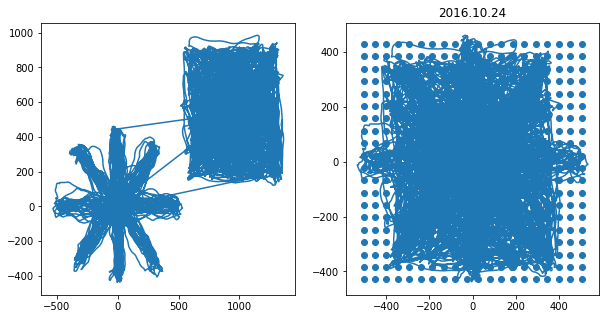

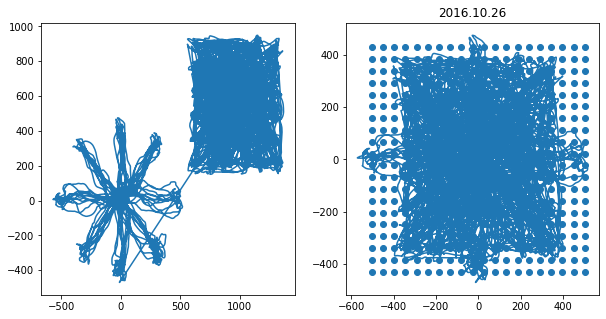

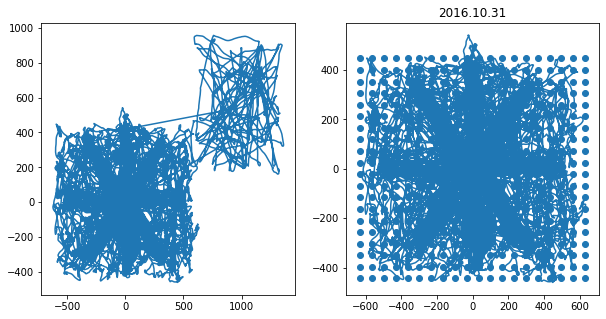

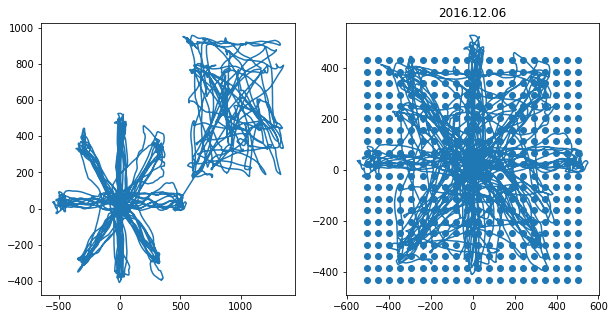

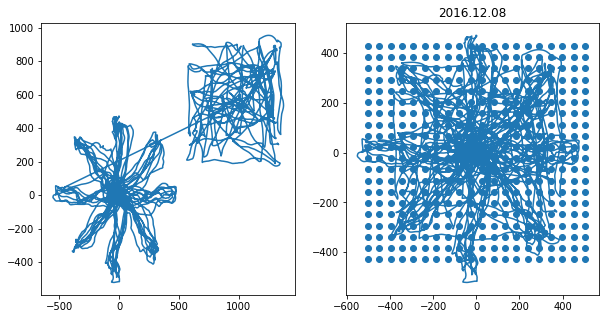

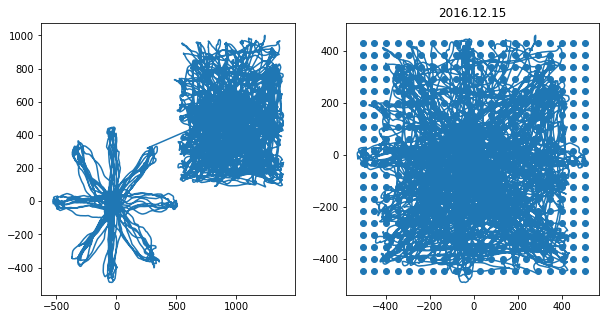

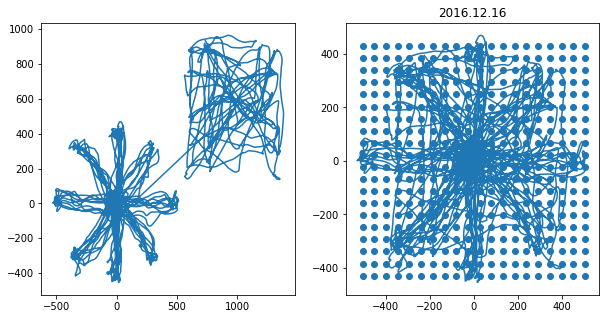

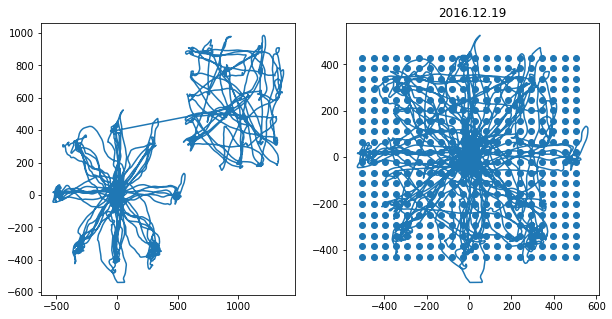

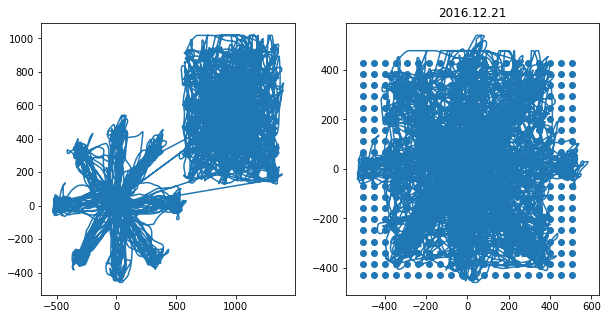

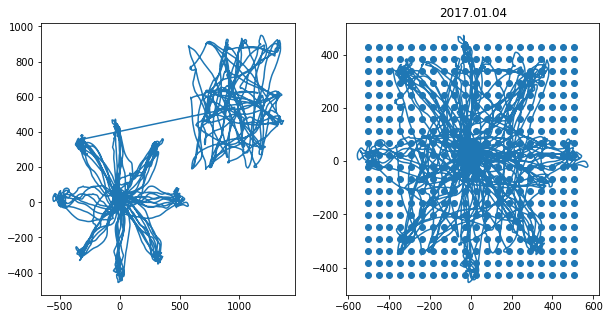

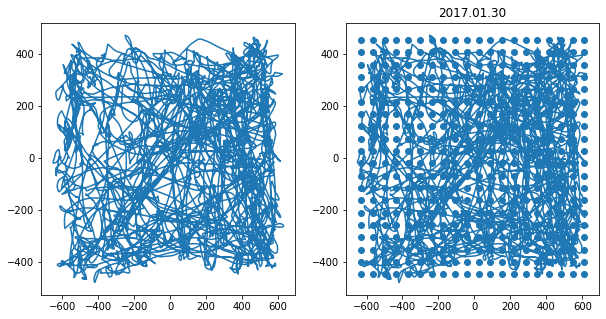

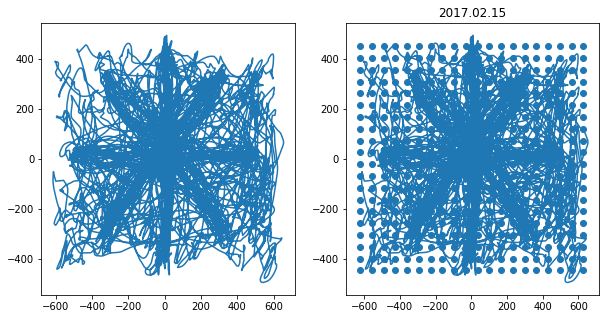

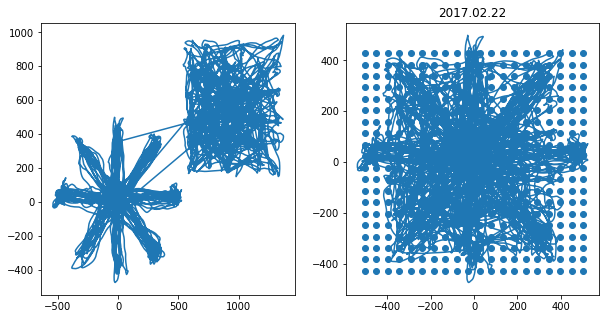

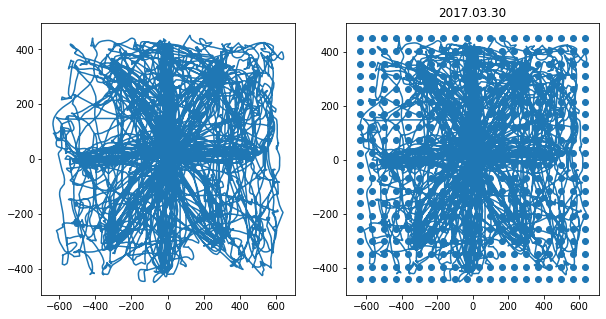

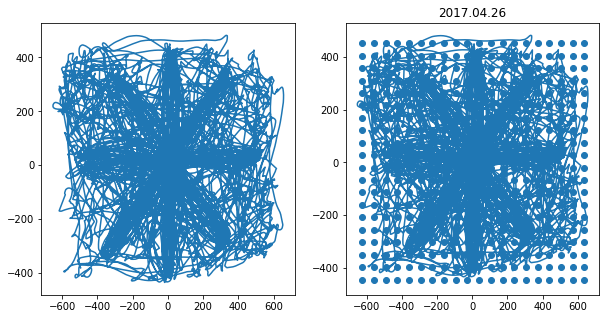

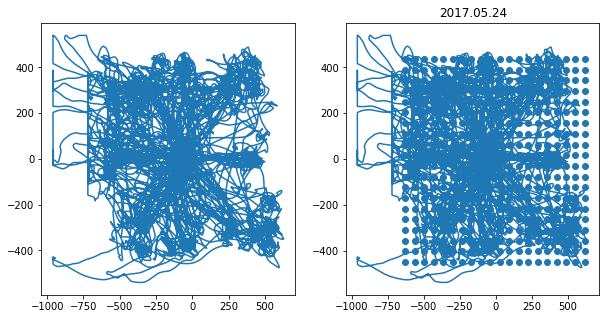

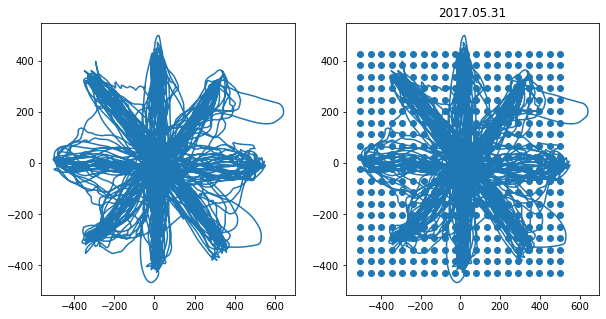

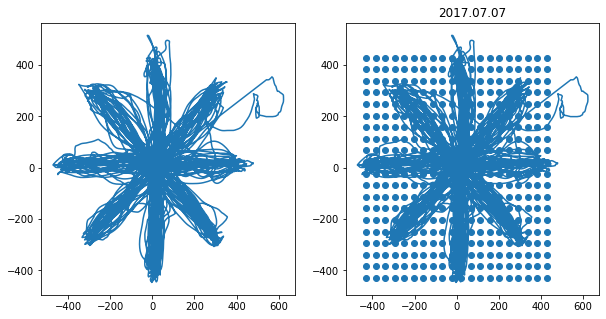

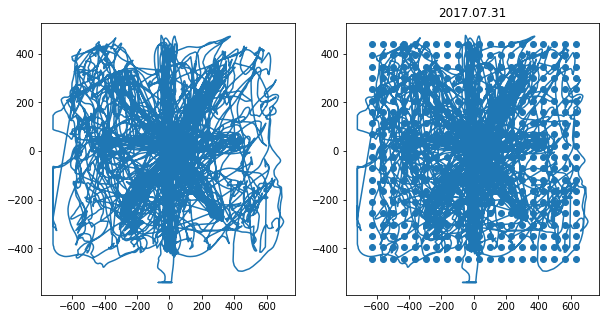

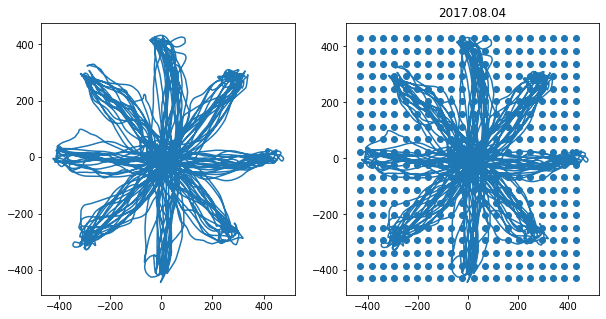

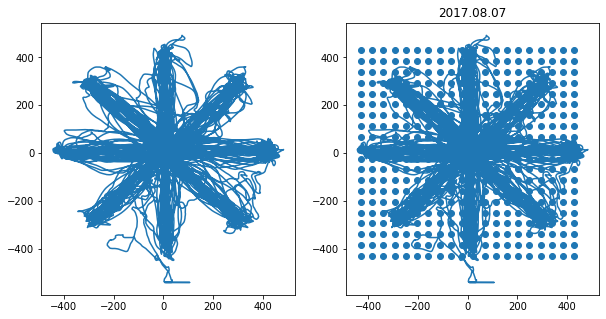

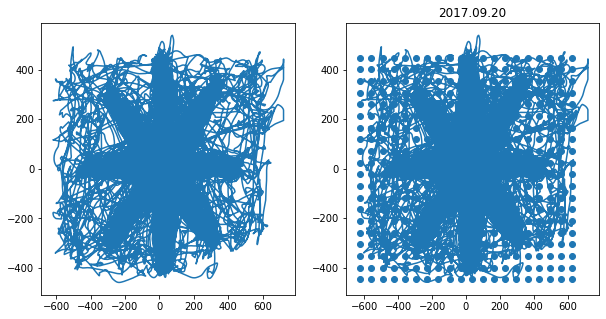

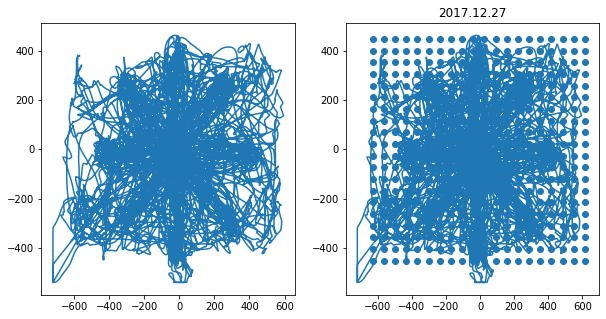

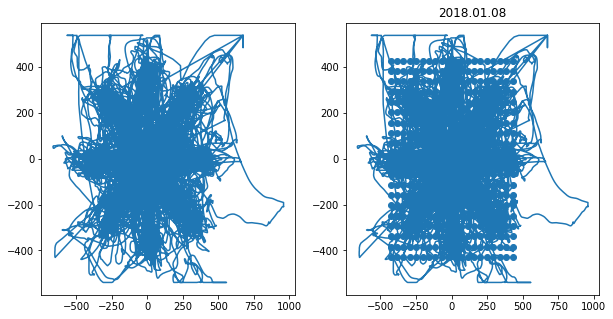

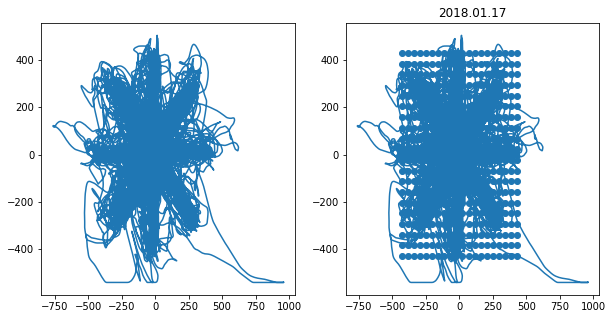

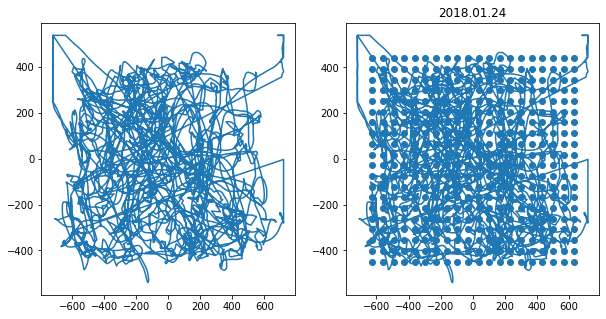

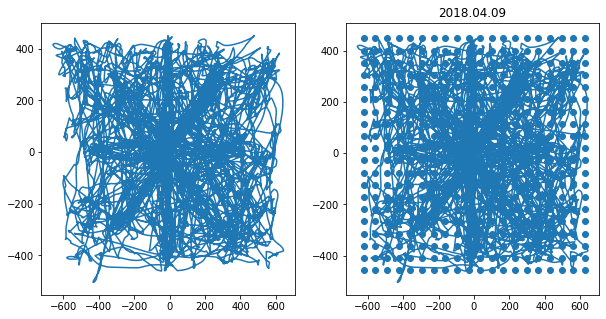

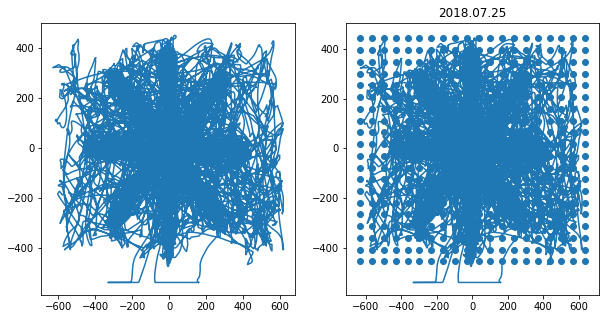

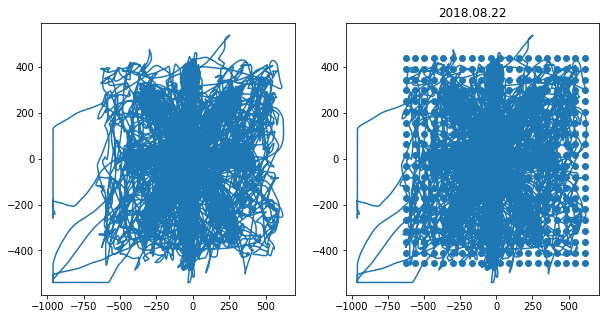

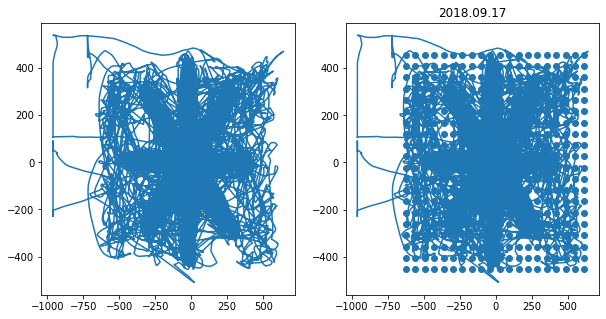

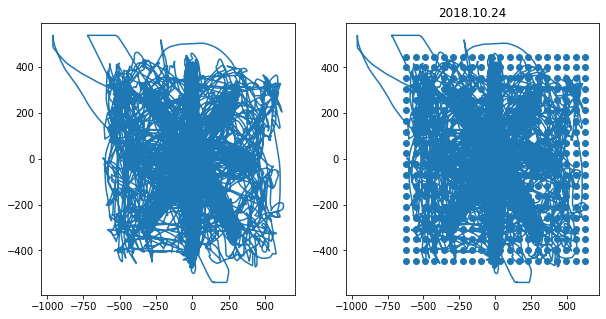

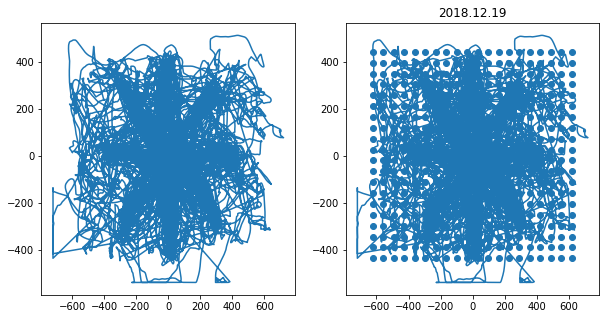

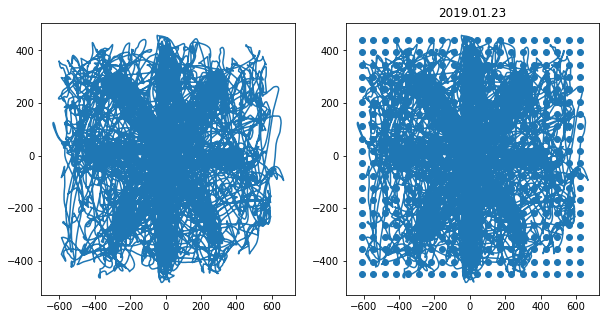

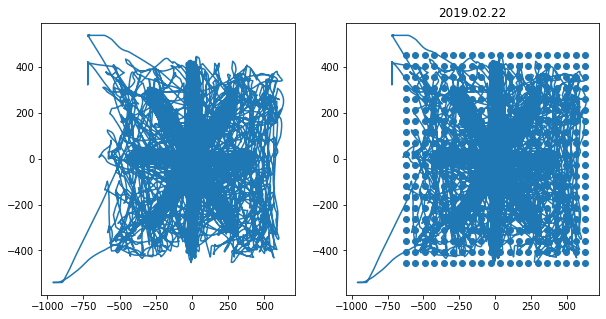

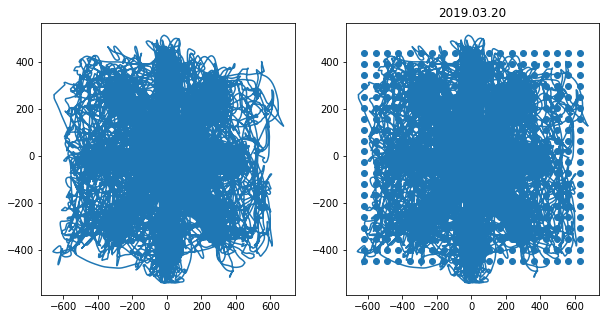

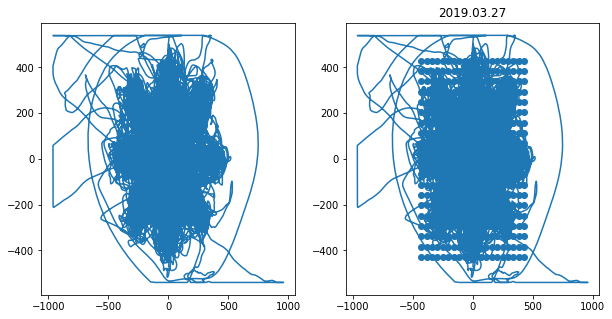

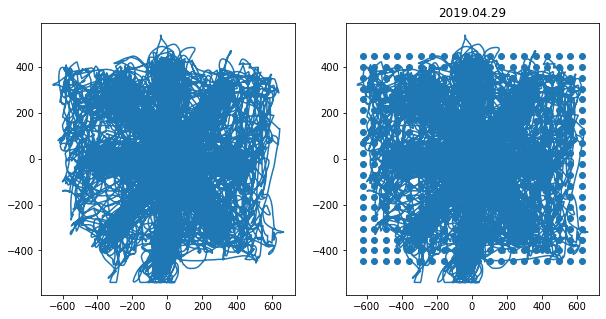

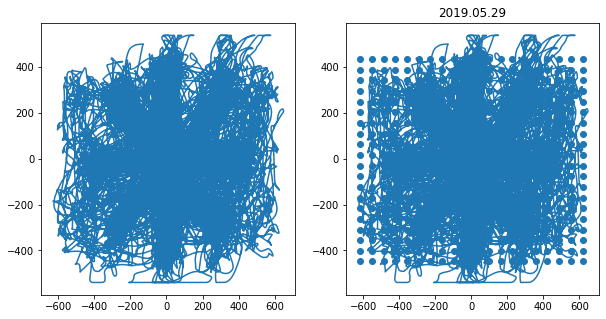

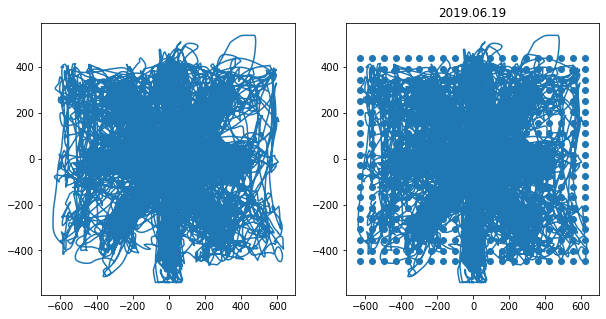

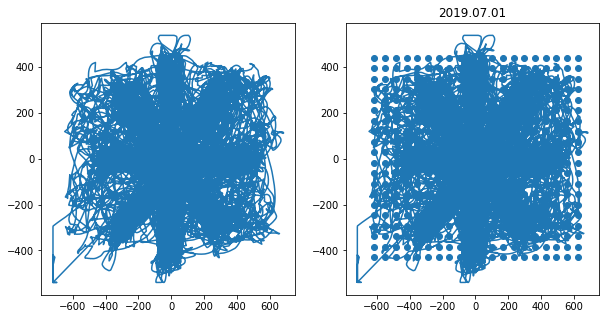

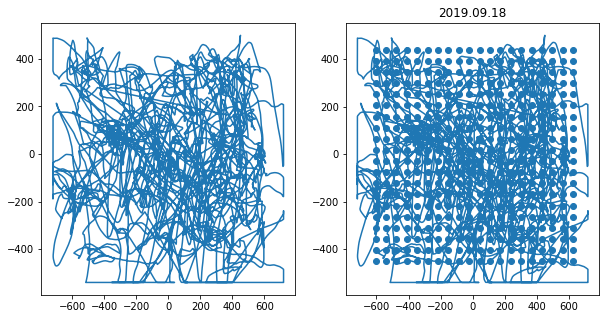

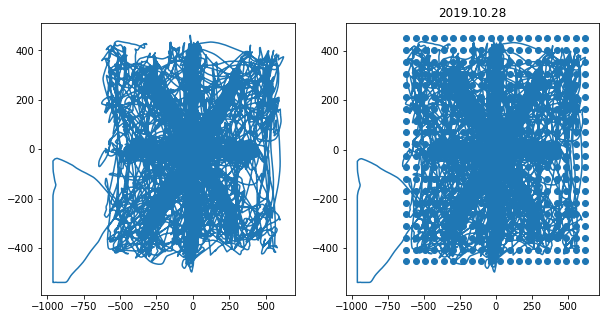

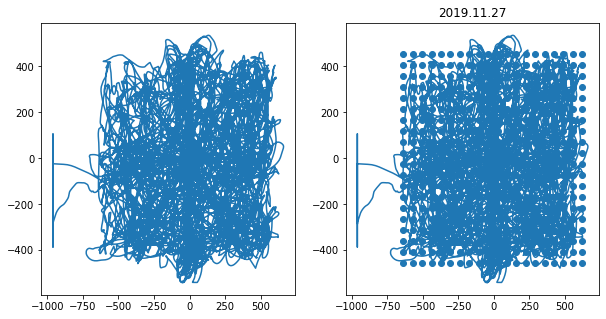

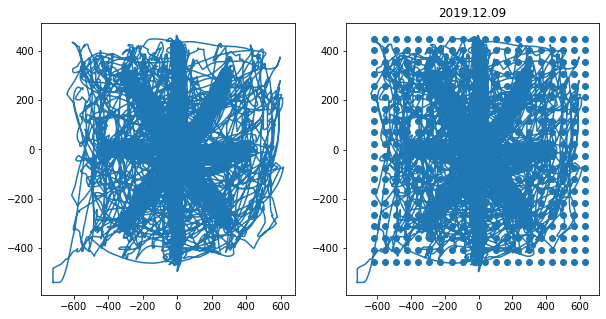

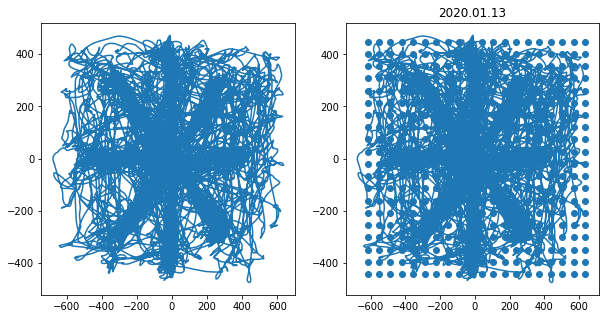

In [242]:
def plotTargLocs(day):
    grid = get_DiscreteTargetGrid(day, gridSize = 20)
    _ = plt.scatter(grid[:, 0], grid[:, 1])

for i, file in enumerate(files):
    
    dayA_none    = DataStruct(file, alignScreens = False, causal_filter = sigma)
    dayA_aligned = DataStruct(file, alignScreens = True, causal_filter = sigma)

    #dayA_aligned = realign(dayA_aligned)

    figSize(5, 10)
    for j, day in enumerate([dayA_none, dayA_aligned]):
        plt.subplot(1, 2, j + 1)
        plt.plot(day.cursorPos_continuous[:, 0], day.cursorPos_continuous[:, 1])
        
        if j == 1:
            plotTargLocs(day)
                
    plt.title(day.date)
    plt.show()
    